In [1]:
import h5py
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

from unet import Unet3D
from diffuser import GaussianDiffusion
import tqdm
from einops import repeat

In [2]:
from data import NaiverStokes_Dataset
from physics_loss import vorticity_residual

In [3]:
ds = NaiverStokes_Dataset('../../data/ns_data_T20_v1e-03_N200.mat')

Loaded 200 samples from ../../data/ns_data_T20_v1e-03_N200.mat
Shape of x: torch.Size([200, 1, 20, 64, 64])


In [6]:
model = Unet3D(
            channels=1,
            cond_channels=1,
            channel_mults=(1, 2, 4, 8, 16),
            init_conv_channels=32,
            init_conv_kernel_size=5
)

diffuser = GaussianDiffusion(
    model=model,
    sample_size=(1, 20, 64, 64),
    timesteps=1000,
    sampling_timesteps=1000,
    objective='pred_noise',
    physics_loss_weight=1.0
).cuda(0)

In [7]:
diffuser.model.load_state_dict(torch.load('./ckpts/ns_V1e-5_T20_1.0phyloss_pred_x0/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [8]:
n = np.random.randint(0, len(ds))
x = ds[n]['x']
x_prev = ds[n]['x_prev']
x_next = ds[n]['x_next']
x_pred = diffuser.sample(cond=ds[n]['y'].unsqueeze(0))

DDPM sampling: 100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


In [9]:
x_pred = x_pred.detach().cpu()
x_pred = x_pred.squeeze()
x = x.squeeze()

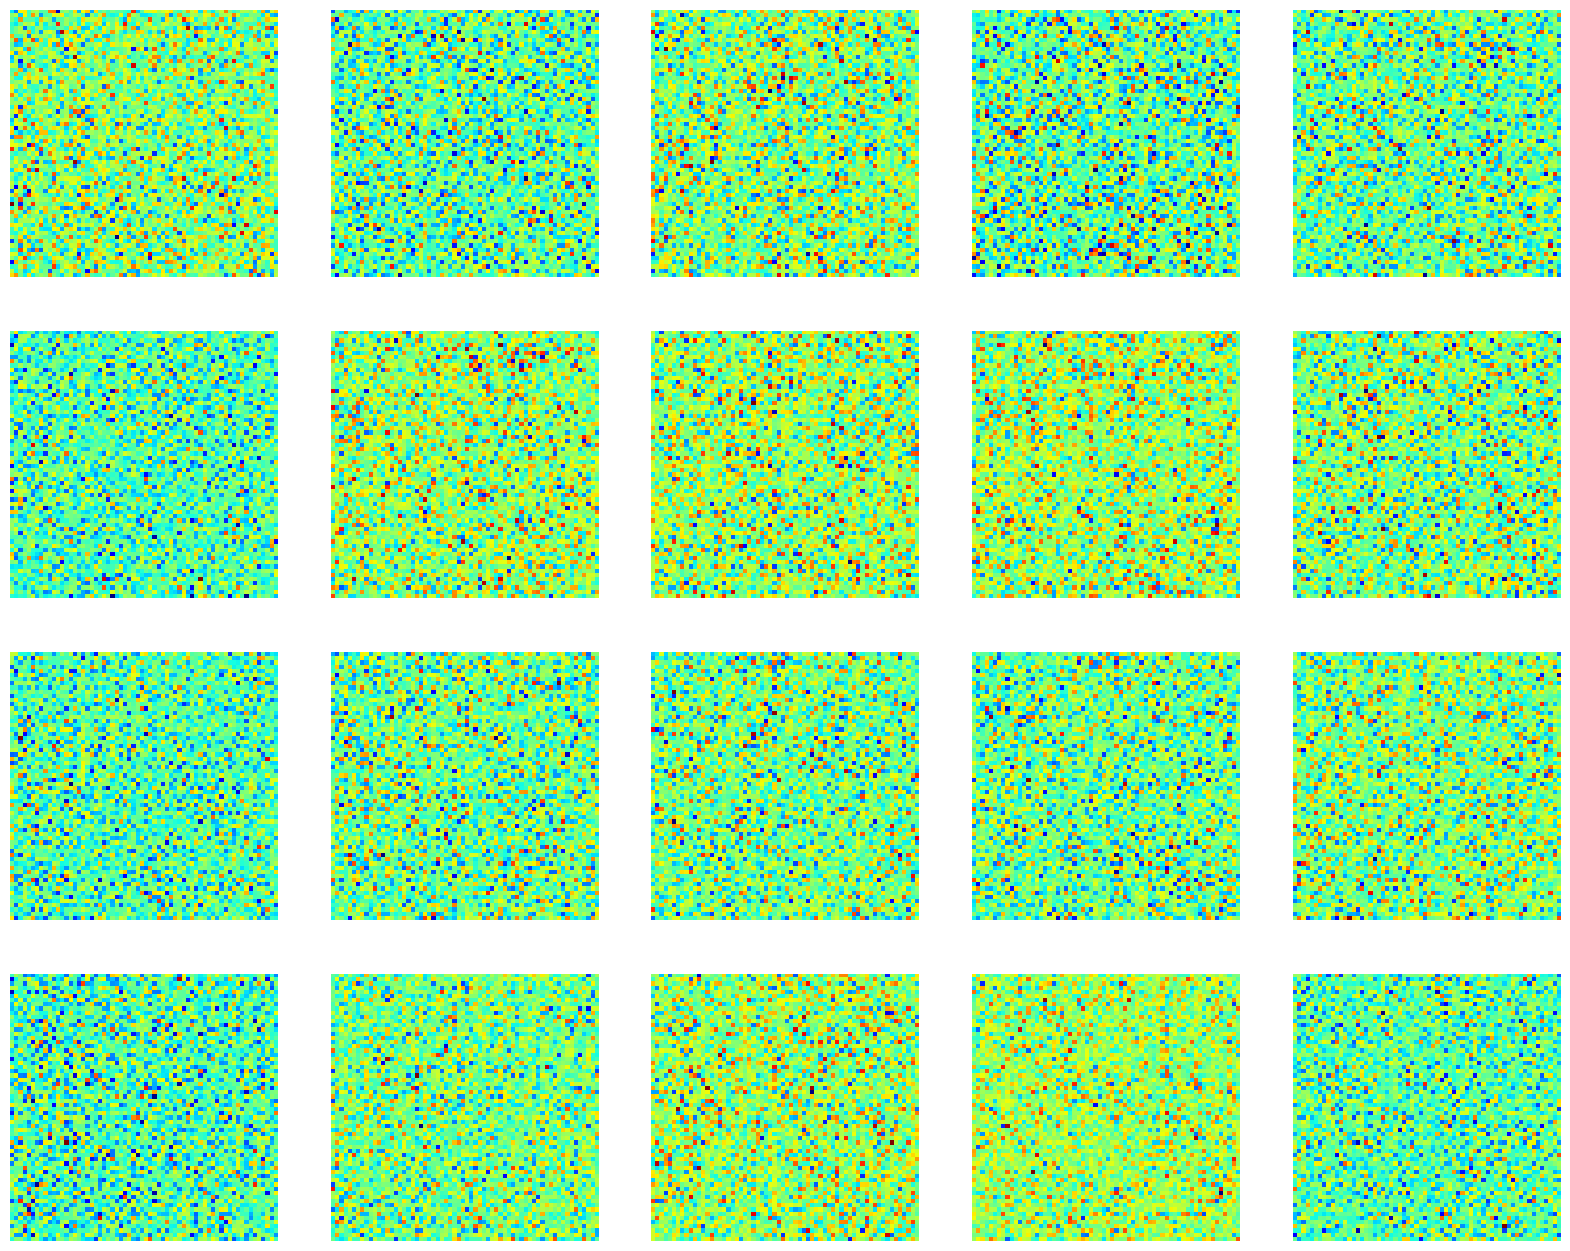

In [10]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16))
ax = ax.flatten()
for i in range(20):
    ax[i].imshow(x_pred[i], cmap='jet')
    ax[i].axis('off')

In [13]:
x_pred = x_pred.unsqueeze(0).unsqueeze(1)

In [14]:
x_prev = x_prev.unsqueeze(0)
x_next = x_next.unsqueeze(0)

In [16]:
phy_loss = vorticity_residual(x_pred, x_prev, x_next, visc=1e-3, dt=1e-3)

In [17]:
phy_loss

tensor(5.1863e+09, grad_fn=<MeanBackward0>)

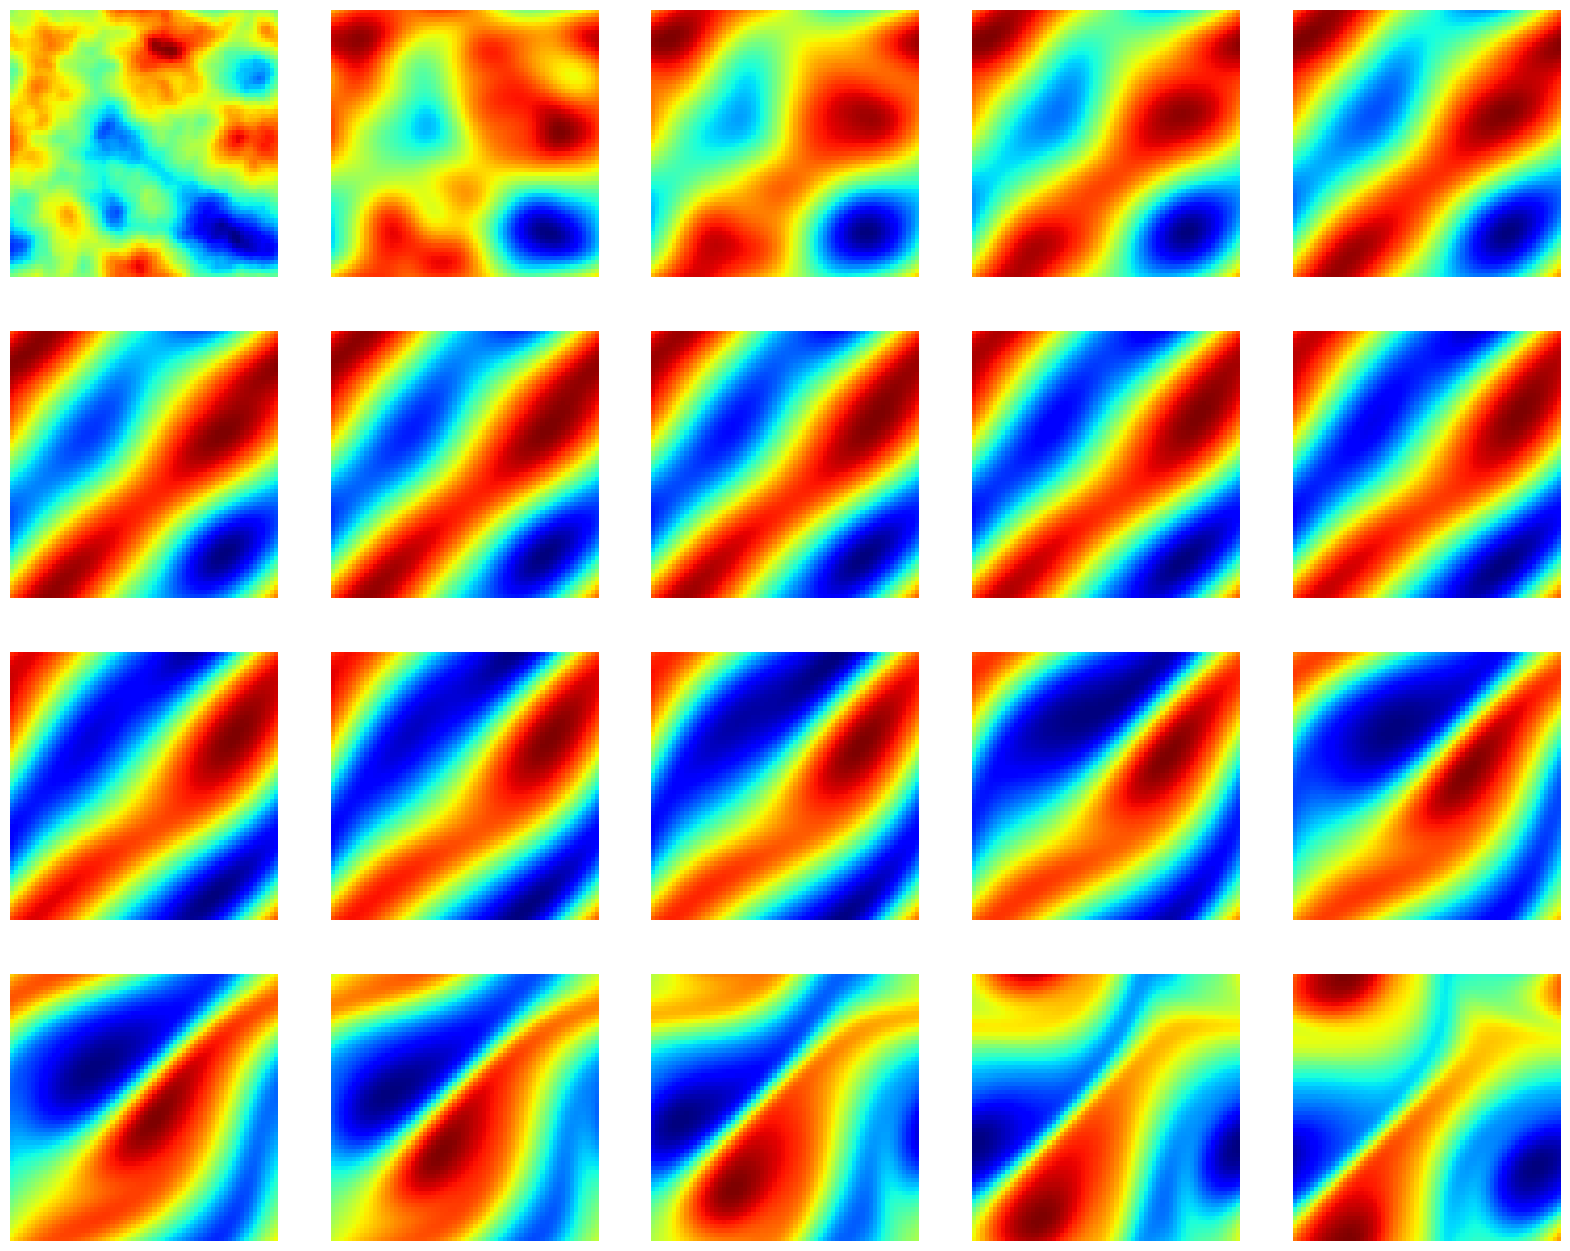

In [11]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16))
ax = ax.flatten()
for i in range(20):
    ax[i].imshow(x[i], cmap='jet')
    ax[i].axis('off')

In [38]:
nt, nx, ny = (20, 64, 64)
k_x = torch.fft.fftfreq(nx, d=1.0)
k_x = repeat(k_x, 'h -> 1 1 1 h 1', h=nx)
k_y = torch.fft.fftfreq(ny, d=1.0)
k_y = repeat(k_y, 'w -> 1 1 1 1 w', w=ny)
k_t = torch.fft.fftfreq(nt, d=1.0)
k_t = repeat(k_t, 't -> 1 1 t 1 1', t=nt)
laplacian_h = (k_x ** 2 + k_y ** 2)
laplacian_h[...,0, 0, 0] = 1e-12

In [1]:
w_h = torch.fft.fftn(x, dim=[-3, -2, -1])
psi_h = w_h / laplacian_h

u_h = 1j * k_y * psi_h
v_h = -1j * k_x * psi_h
wx_h = 1j * k_x * w_h
wy_h = 1j * k_y * w_h
wt_h = 1j * k_t * w_h
wlaplacian_h = -laplacian_h * w_h

u = torch.fft.irfftn(u_h, u_h.shape[-3:])
v = torch.fft.irfftn(v_h, v_h.shape[-3:])
wx = torch.fft.irfftn(wx_h, wx_h.shape[-3:])
wy = torch.fft.irfftn(wy_h, wy_h.shape[-3:])
wt = torch.fft.irfftn(wt_h, wt_h.shape[-3:])
wlaplacian = torch.fft.irfftn(wlaplacian_h, wlaplacian_h.shape[-3:])
advection = (u * wx + v * wy)

xx = torch.linspace(0, 1.0, nx + 1)
xx = xx[0:-1]
X, Y = torch.meshgrid(xx, xx, indexing='ij')
f = 0.1*(torch.sin(2*torch.pi*(X+Y)) + torch.cos(2*torch.pi*(X+Y)))

residual = wt + (advection - 1e-5 * wlaplacian) - f

NameError: name 'torch' is not defined

In [45]:
w_h_pred = torch.fft.fftn(torch.randn(1, 1, 20, 64, 64), dim=[-3, -2, -1])
psi_h_pred = w_h_pred / laplacian_h

u_h_pred = 1j * k_y * psi_h_pred
v_h_pred = -1j * k_x * psi_h_pred
wx_h_pred = 1j * k_x * w_h_pred
wy_h_pred = 1j * k_y * w_h_pred
wt_h_pred = 1j * k_t * w_h_pred
wlaplacian_h_pred = -laplacian_h * w_h_pred

u_pred = torch.fft.irfftn(u_h_pred, u_h_pred.shape[-3:])
v_pred = torch.fft.irfftn(v_h_pred, v_h_pred.shape[-3:])
wx_pred = torch.fft.irfftn(wx_h_pred, wx_h_pred.shape[-3:])
wy_pred = torch.fft.irfftn(wy_h_pred, wy_h_pred.shape[-3:])
wt_pred = torch.fft.irfftn(wt_h_pred, wt_h_pred.shape[-3:])
wlaplacian_pred = torch.fft.irfftn(wlaplacian_h_pred, wlaplacian_h_pred.shape[-3:])
advection_pred = (u_pred * wx_pred + v_pred * wy_pred)

xx = torch.linspace(0, 1.0, nx + 1)
xx = xx[0:-1]
X, Y = torch.meshgrid(xx, xx, indexing='ij')
f = 0.1*(torch.sin(2*torch.pi*(X+Y)) + torch.cos(2*torch.pi*(X+Y)))

residual_pred = wt_pred + (advection_pred - 1e-5 * wlaplacian_pred) - f

In [46]:
torch.mean(residual_pred)

tensor(1.6298e-10)

In [41]:
loss = torch.mean((residual_pred - residual)**2)

In [42]:
loss

tensor(2.5075)

In [8]:
diffuser.denoising_fn.load_state_dict(torch.load('./ckpts/ns_V1e-5_T20_0.1phyloss/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [9]:
x_pred_01phyloss = diffuser.sample(cond=ds[n]['y'].unsqueeze(0))
x_pred_01phyloss = x_pred_01phyloss.detach().cpu()
x_pred_01phyloss = x_pred_01phyloss.squeeze()

DDPM sampling: 100%|██████████| 1000/1000 [00:47<00:00, 20.97it/s]


In [10]:
diffuser.denoising_fn.load_state_dict(torch.load('./ckpts/ns_V1e-5_T20_0.5phyloss/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [11]:
x_pred_05phyloss = diffuser.sample(cond=ds[n]['y'].unsqueeze(0))
x_pred_05phyloss = x_pred_05phyloss.detach().cpu()
x_pred_05phyloss = x_pred_05phyloss.squeeze()

DDPM sampling: 100%|██████████| 1000/1000 [00:47<00:00, 20.98it/s]


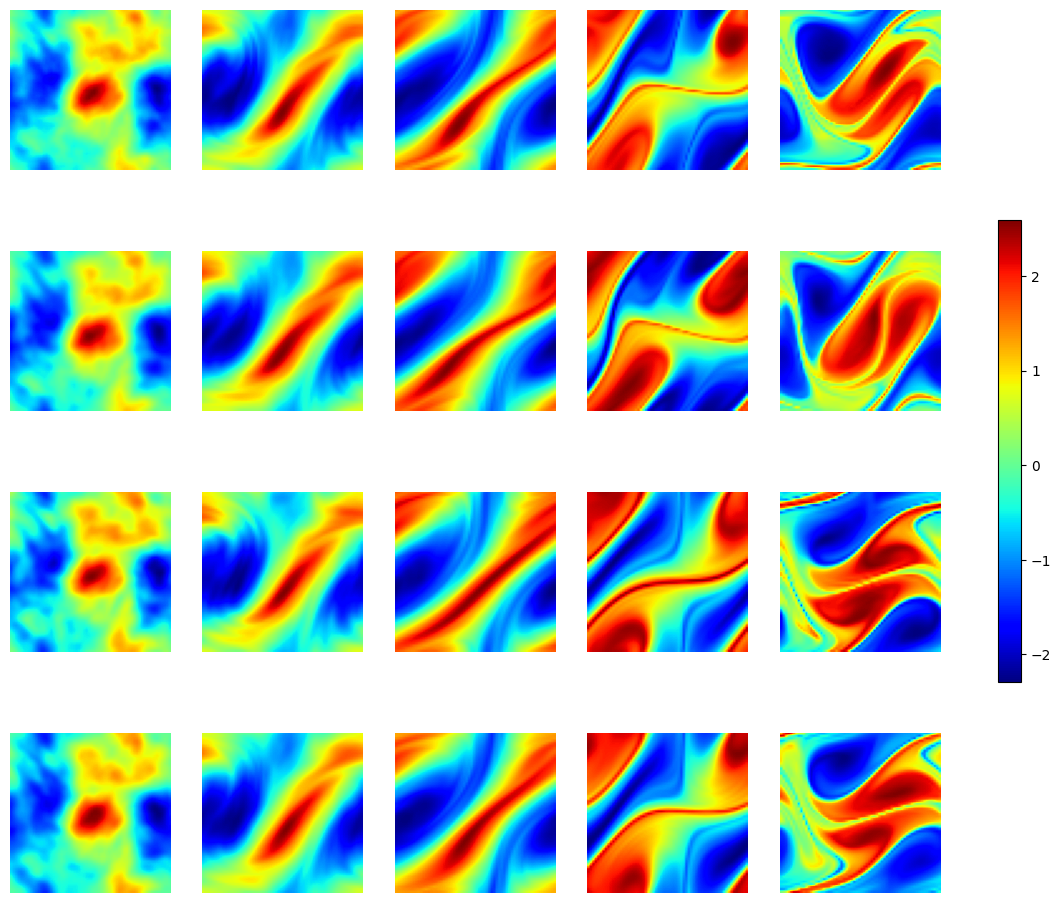

In [12]:
show_idxs = [0, 4, 9, 14, 19]
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
for i in range(5):
    im = ax[0, i].imshow(x[show_idxs[i]], cmap='jet')
    ax[0, i].axis('off')
    im = ax[1, i].imshow(x_pred[show_idxs[i]], cmap='jet')
    ax[1, i].axis('off')
    im = ax[2, i].imshow(x_pred_01phyloss[show_idxs[i]], cmap='jet')
    ax[2, i].axis('off')
    im = ax[3, i].imshow(x_pred_05phyloss[show_idxs[i]], cmap='jet')
    ax[3, i].axis('off')
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)
    

In [13]:
diffuser.denoising_fn.load_state_dict(torch.load('./ckpts/ns_V1e-5_T20/ckpt.pt')['model_state_dict'])

<All keys matched successfully>

In [14]:

with torch.no_grad():
    y = ds[57]['y'].unsqueeze(0).cuda(0)
    xt = torch.randn(1, *diffuser.sample_size).cuda(0)
    x0_recons = []

    for t in tqdm.tqdm(reversed(range(0, diffuser.num_timesteps)), total=diffuser.num_timesteps):
        batched_t = torch.full((xt.shape[0],), t, dtype=torch.long, device=xt.device)
        eps_theta = diffuser.denoising_fn(xt, batched_t, cond=y)
        x0_recon = diffuser.predict_x0_from_xt(xt=xt, t=batched_t, eps=eps_theta)
        xt = diffuser.p_sample(xt=xt, t=t, cond=y)
        if t % 10 == 0:
            x0_recons.append(x0_recon)

100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]


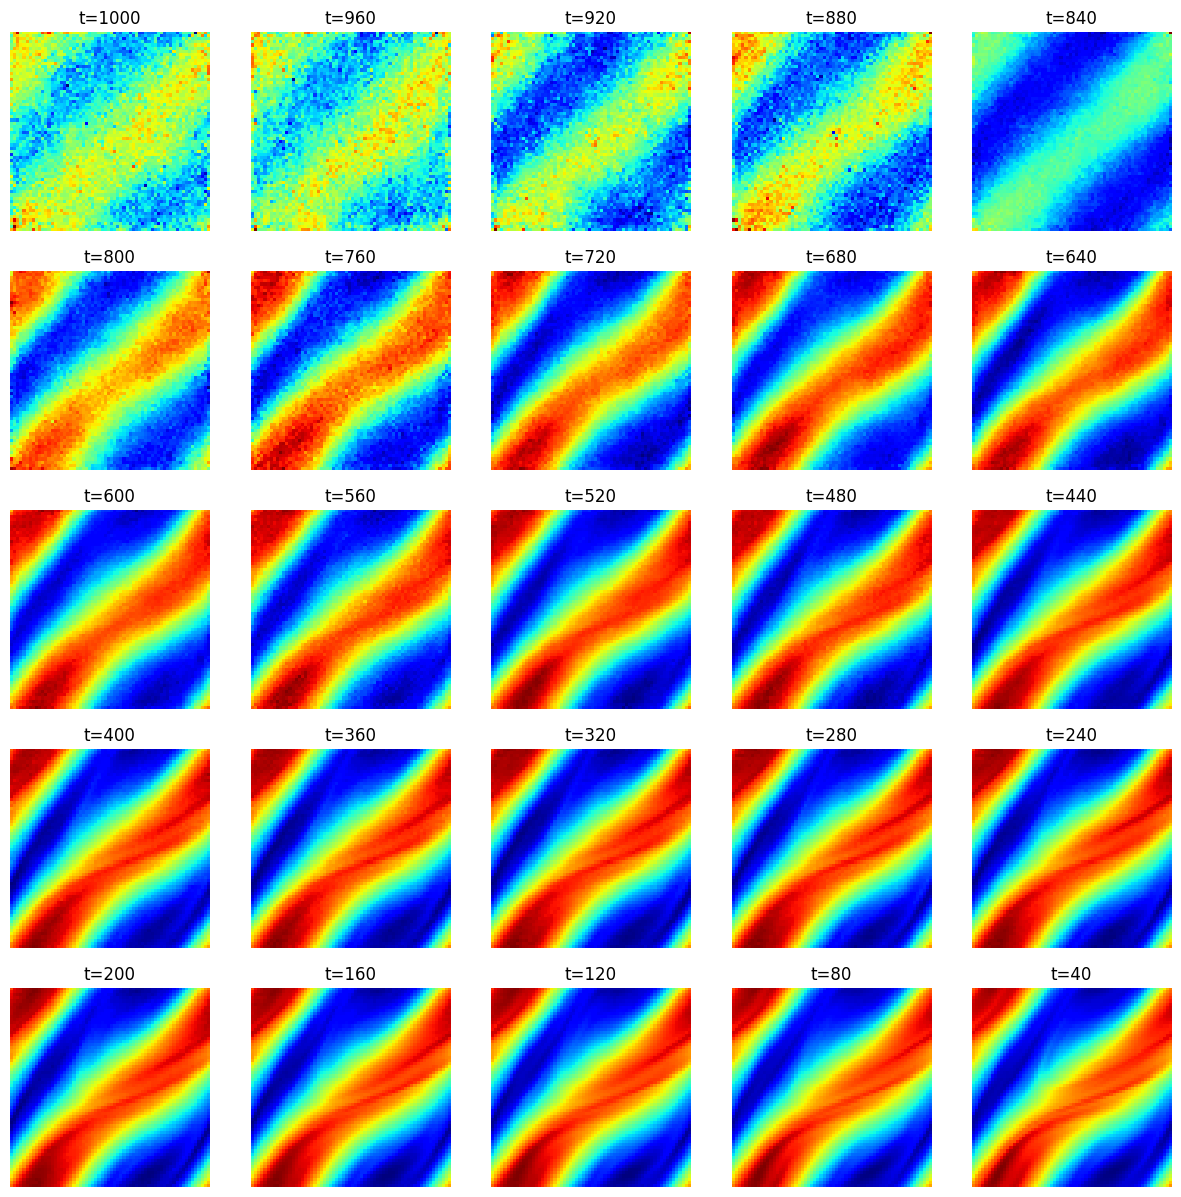

In [15]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(x0_recons[(i*5+j)*4][0, 0, 10].cpu(), cmap='jet')
        ax[i, j].axis('off')
        ax[i, j].set_title(f't={1000-(i*5+j)*40}')